In [1]:
##코랩실행시 google driver mount 하기
#from google.colab import drive
#drive.mount('/content/drive')
#% cd /content/drive/My Drive/FAS


# 3D_Dilated CNN with meta
- Clahe
- Data Aug_abnormal case_Over Sampling

In [1]:
# Download packages
!pip install pydicom
!pip install imgaug
!pip install cv2
!pip install tensorflow
!pip install keras 

  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached Shapely-1.7.1-cp38-cp38-manylinux1_x86_64.whl (1.0 MB)
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
     |████████████████████████████████| 26.0 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 11.8 MB/s eta 0:00:01


  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled scipy-1.5.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
Processing /home/niausr/.cache/pip/wheels/13/90/db/290ab3a34f2ef0b5a0f89235dc2d40fea83e77de84ed2dc05c/PyYAML-5.3.1-cp38-cp38-linux_x86_64.whl


In [1]:
# Load Libraries
import pydicom as pdc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import glob
import pydicom as pdc
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
#import tensorflow_hub as hub
from skimage import exposure
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
#path = './metadata/'
path = '../Diagnosis_Gallbladder_Cancer/metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
# Phase feature 는 제거
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX']])], axis=1)
patient_meta = patient_meta.drop(['SEX','PHASE'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 0 : Metastasis, 56
# 1 : Hepatocelluar Carcinoma, 30
# 2 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 0
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    else:
        patient_meta.iloc[r, 1] = -1

patient_meta = np.array(patient_meta)   #넘파이 배열로 변환

Drop: Int64Index([42, 66, 69], dtype='int64')


In [6]:
# 데이터 전처리 중간 점검
patient_meta

array([['SN00180816', 1, 0, 1, -0.9717086332456366],
       ['SN00361989', 1, 1, 0, -1.0655029028639413],
       ['SN00481545', 2, 1, 0, 0.9041767591204574],
       ['SN00493709', 2, 0, 1, 0.43520541102893384],
       ['SN00181638', 0, 0, 1, -0.31514874591750375],
       ['SN00222863', 0, 0, 1, 0.15382260217401975],
       ['SN00283964', 0, 0, 1, 0.997971028738762],
       ['SN00304545', 0, 1, 0, 0.9041767591204574],
       ['SN00450700', 2, 1, 0, 0.7165882198838479],
       ['SN00508749', 1, 0, 1, 0.997971028738762],
       ['SN00090078', 0, 1, 0, -0.03376593706258964],
       ['SN00369027', 0, 1, 0, -0.31514874591750375],
       ['SN00474278', 0, 1, 0, -1.44067998133716],
       ['SN00305004', 0, 1, 0, -1.3468857117188553],
       ['SN00508618', 0, 0, 1, 0.997971028738762],
       ['SN00067936', 0, 1, 0, -2.4724169471385116],
       ['SN00381399', 2, 0, 1, -0.6903258243907225],
       ['SN00407113', 1, 1, 0, 1.0917652983570667],
       ['SN00097002', 1, 0, 1, 1.3731481072119809],
   

In [7]:
label_df = pd.read_csv('../Diagnosis_Gallbladder_Cancer/metadata/label_df.csv')
#label_df = pd.read_csv('./metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


- Z축을 5만큼 잘라서 작업
- Clahe 전처리를 시켜주고, resize는 normalize 후 처리해준다 ( resize = (64,64) )

In [8]:
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
size = (64,64)
n_ct_statistics=[]
path = '../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/'
#
# 10-cv Settings
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []
    X_p_tr_abnormal, X_m_tr_abnormal, X_i_tr_abnormal ,Y_tr_abnormal = [], [], [], [] 
    for tr_idx in tr_list:
        X_i_tr_ct_list = sorted(glob.glob(path+patient_meta[tr_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_tr_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
            # 전처리 --> normalize --> resize   
            ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
        ct_block = np.array(ct_block)
         # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[tr_idx, 0],'DX']
        dx_block = np.array(dx_block)
    
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1   # for 문 마지막 인덱스 설정
        X_i_tr_buffer = []
        X_i_tr_abnormal_buffer = []
        # 환자의 진단명에 따라 다르게 저장해준다.
        # 0 이면 일반 리스트
        # 0 이아니면 abnormal 리스트 
        for z in range(n_window):
            maxVal = np.max(dx_block[z:z+window_size])
            if (maxVal != 0 ):
                X_i_tr_abnormal_buffer.append(ct_block[z:z+window_size])   # 설정된 윈도우 사이즈 만큼 사진을 가져온다.
                X_p_tr_abnormal.append(patient_meta[tr_idx, 0])            # 환자 번호
                X_m_tr_abnormal.append(patient_meta[tr_idx, 2:])           # 환자 메타 정보
                Y_tr_abnormal.append(maxVal)                               # DX
            else :
                X_i_tr_buffer.append(ct_block[z:z+window_size])   # 설정된 윈도우 사이즈 만큼 사진을 가져온다.
                X_p_tr.append(patient_meta[tr_idx, 0])            # 환자 번호
                X_m_tr.append(patient_meta[tr_idx, 2:])           # 환자 메타 정보 
                Y_tr.append(maxVal)                               # DX
            
  
        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
        X_i_tr_abnormal_buffer = np.array(X_i_tr_abnormal_buffer)
        X_i_tr_abnormal.extend(X_i_tr_abnormal_buffer)
        
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr), np.array(Y_tr)
    X_p_tr_abnormal, X_m_tr_abnormal, X_i_tr_abnormal, Y_tr_abnormal = np.array(X_p_tr_abnormal), np.array(X_m_tr_abnormal), np.array(X_i_tr_abnormal), np.array(Y_tr_abnormal)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
    print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape)
    
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []
    for te_idx in te_list:
        X_i_te_ct_list = sorted(glob.glob(path+patient_meta[te_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_te_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
                ct_block.append(cv2.resize(cv2.normalize((pdc.dcmread(X_i_te_ct_list[z])).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),dsize=size))
        ct_block = np.array(ct_block)
        
        # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[te_idx, 0],'DX']
        dx_block = np.array(dx_block)
  
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size])
            X_p_te.append(patient_meta[te_idx, 0])
            X_m_te.append(patient_meta[te_idx, 2:])

            maxVal = np.max(dx_block[z:z+window_size])
            Y_te.append(maxVal)                               # DX
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
    X_p_te, X_m_te, X_i_te, Y_te = np.array(X_p_te), np.array(X_m_te), np.array(X_i_te), np.array(Y_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
    break

(8665,) (8665, 3) (8665, 5, 64, 64) (8665,)
(2117,) (2117, 3) (2117, 5, 64, 64) (2117,)
(2625,) (2625, 3) (2625, 5, 64, 64) (2625,)


In [9]:
print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape)

(2117,) (2117, 3) (2117, 5, 64, 64) (2117,)


In [10]:
# CT Length Statistics
np.mean(n_ct_statistics)

138.07

In [11]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr_abnormal[Y_tr_abnormal==1]), len(Y_tr_abnormal[Y_tr_abnormal==2]), len(Y_tr_abnormal[Y_tr_abnormal==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

8665 1036 688 393
2138 335 117 35


In [12]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
np.save(path+'X_p_tr_final2', X_p_tr), np.save(path+'X_m_tr_final2', X_m_tr), np.save(path+'X_i_tr_final2', X_i_tr), np.save(path+'Y_tr_final2', Y_tr)
np.save(path+'X_p_te_final2', X_p_te), np.save(path+'X_m_te_final2', X_m_te), np.save(path+'X_i_te_final2', X_i_te), np.save(path+'Y_te_final2', Y_te)
np.save(path+'X_p_tr_abnormal_final2', X_p_tr_abnormal), np.save(path+'X_m_tr_abnormal_final2', X_m_tr_abnormal), np.save(path+'X_i_tr_abnormal_final2', X_i_tr_abnormal), np.save(path+'Y_tr_abnormal_final2', Y_tr_abnormal)
#np.save(path+'np/X_p_te_abnormal_final2', X_p_te_abnormal), np.save(path+'np/X_m_te_abnormal_final2', X_m_te_abnormal), np.save(path+'np/X_i_te_abnormal_final2', X_i_te_abnormal), np.save(path+'np/Y_te_abnormal_final2', Y_te_abnormal)

(None, None, None, None)

In [13]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape)

(8665,) (8665, 3) (8665, 5, 64, 64) (8665,)
(2625,) (2625, 3) (2625, 5, 64, 64) (2625,)
(2117,) (2117, 3) (2117, 5, 64, 64) (2117,)


### Augmentation 작업 전

In [14]:
# Load Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final2.npy'), np.load(path+'X_m_tr_final2.npy', allow_pickle=True), np.load(path+'X_i_tr_final2.npy'), np.load(path+'Y_tr_final2.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final2.npy'), np.load(path+'X_m_te_final2.npy', allow_pickle=True), np.load(path+'X_i_te_final2.npy'), np.load(path+'Y_te_final2.npy')
X_p_tr_abnormal, X_m_tr_abnormal, X_i_tr_abnormal, Y_tr_abnormal = np.load(path+'X_p_tr_abnormal_final2.npy'), np.load(path+'X_m_tr_abnormal_final2.npy', allow_pickle=True), np.load(path+'X_i_tr_abnormal_final2.npy'), np.load(path+'Y_tr_abnormal_final2.npy')

X_m_tr, X_m_te, X_m_tr_abnormal = X_m_tr.astype('float32'), X_m_te.astype('float32'), X_m_tr_abnormal.astype('float32')
Y_tr_cat, Y_te_cat, Y_tr_abnormal_cat  = to_categorical(Y_tr), to_categorical(Y_te), to_categorical(Y_tr_abnormal) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)
print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape, Y_tr_abnormal_cat.shape)

(8665,) (8665, 3) (8665, 5, 64, 64) (8665,) (8665, 1)
(2625,) (2625, 3) (2625, 5, 64, 64) (2625,) (2625, 4)
(2117,) (2117, 3) (2117, 5, 64, 64) (2117,) (2117, 4)


In [5]:
'''
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
X_i_tr_abnormal = np.rollaxis(X_i_tr_abnormal, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)
print(X_i_tr_abnormal.shape)
'''

(8462, 64, 64, 5)
(2752, 64, 64, 5)
(2193, 64, 64, 5)


### Augmentation 작업 후

In [53]:
# Augmentations
import imgaug as ia
import imgaug.augmenters as iaa
window_size = 5
n_aug = 8
path = './np/'
#path = './benchmark_liver_tumor/raw/np/'
for a in range(n_aug):
    seq_pipeline = iaa.Sequential([
        iaa.Sometimes(0.5, iaa.Fliplr(0.5)),   # horizontally flip 50% of all image 
        iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.1))), # 0-10% 비율로 높이와 너비를 잘라준다.
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.Sometimes(0.5, iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},   # x,y축 모두 80-120% 크기변환
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # x,y 축모두 -20 에서 +20으로 축변환
            rotate=(-25, 25),  # -25 에서 25 도 각도 변화
            shear=(-8, 8))), # -16에서 16 기울기 변화
        iaa.Sometimes(0.5, iaa.LinearContrast((0.75, 1.5))) # 이미지의 대조를 악화시키거나 개선 시킨다.
        ## 추가해 볼 기법들
        # mixup
    ], random_order=True)
    X_i_tr_abnormal_aug = np.copy(X_i_tr_abnormal)
    for r in range(X_i_tr_abnormal_aug.shape[0]):
        buffer_block = X_i_tr_abnormal_aug[r]
        for z in range(window_size):
            buffer_block[z] = seq_pipeline(images=buffer_block[z])
        X_i_tr_abnormal_aug[r] = buffer_block
    X_p_tr_abnormal_aug, X_m_tr_abnormal_aug, Y_tr_abnormal_aug = np.copy(X_p_tr_abnormal), np.copy(X_m_tr_abnormal), np.copy(Y_tr_abnormal)
    np.save(path+'X_p_tr_abnormal_aug_%02d' %(a), X_p_tr_abnormal_aug), np.save(path+'X_m_tr_abnormal_aug_%02d' %(a), X_m_tr_abnormal_aug), np.save(path+'X_i_tr_abnormal_aug_%02d' %(a), X_i_tr_abnormal_aug), np.save(path+'Y_tr_abnormal_aug_%02d' %(a), Y_tr_abnormal_aug)

In [54]:
# Load Augmented Dataset and concat with original train Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
n_aug = 8
for a in range(n_aug):
    X_p_buffer, X_m_buffer, X_i_buffer, Y_tr_buffer = np.load(path+'X_p_tr_abnormal_aug_%02d.npy' %(a)), np.load(path+'X_m_tr_abnormal_aug_%02d.npy' %(a), allow_pickle=True).astype('float32'), np.load(path+'X_i_tr_abnormal_aug_%02d.npy' %(a)), np.load(path+'Y_tr_abnormal_aug_%02d.npy' %(a))
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.concatenate((X_p_tr, X_p_buffer), axis=0), np.concatenate((X_m_tr, X_m_buffer), axis=0), np.concatenate((X_i_tr, X_i_buffer), axis=0), np.concatenate((Y_tr, Y_tr_buffer), axis=0)
Y_tr_cat = to_categorical(Y_tr)
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(26006,) (26006, 3) (26006, 64, 64, 5) (26006,) (26006, 4)
(2752,) (2752, 3) (2752, 64, 64, 5) (2752,) (2752, 4)


### Save augmented Dataset 
- 여기서 부터 실행

In [2]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/np_3d_oversample/'
path = './np_aug_2_oversampling/'
np.save(path+'X_p_tr_final22', X_p_tr), np.save(path+'X_m_tr_final22', X_m_tr), np.save(path+'X_i_tr_final22', X_i_tr), np.save(path+'Y_tr_final22', Y_tr)
np.save(path+'X_p_te_final22', X_p_te), np.save(path+'X_m_te_final22', X_m_te), np.save(path+'X_i_te_final22', X_i_te), np.save(path+'Y_te_final22', Y_te)

NameError: name 'X_p_tr' is not defined

### Load final Dataset

In [2]:
# Load Dataset
#path = './benchmark_liver_tumor/raw/np_3d_oversample/'
path = './np_aug_2_oversampling/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final22.npy'), np.load(path+'X_m_tr_final22.npy', allow_pickle=True), np.load(path+'X_i_tr_final22.npy'), np.load(path+'Y_tr_final22.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final22.npy'), np.load(path+'X_m_te_final22.npy', allow_pickle=True), np.load(path+'X_i_te_final22.npy'), np.load(path+'Y_te_final22.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(26006,) (26006, 3) (26006, 64, 64, 5) (26006,) (26006, 4)
(2752,) (2752, 3) (2752, 64, 64, 5) (2752,) (2752, 4)


In [3]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

8462 8936 5832 2776
2341 254 76 81


In [ ]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
#X_i_tr_abnormal = np.rollaxis(X_i_tr_abnormal, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)
#print(X_i_tr_abnormal.shape)

In [4]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
#h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)


# Build Meta-data
dnn_input = tf.keras.Input((X_m_tr.shape[1],))
h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)


# Fusion Model
concat = tf.keras.layers.Concatenate(axis=-1)([cnn_output, dnn_output])
h = tf.keras.layers.Dense(128, activation='tanh')(concat)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn_meta = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=cnn_dnn_output)
cnn_meta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_meta.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 64, 64, 5, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 64, 64, 5, 16 144         reshape[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 32, 32, 5, 16 0           conv3d[0][0]                     
______________________________________________________________________________________________

In [5]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

8462 8936 5832 2776
2341 254 76 81


In [5]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn_meta.fit([X_i_tr,X_m_tr], Y_tr_cat, validation_data=([X_i_te,X_m_te], Y_te_cat), epochs=200, batch_size=30, shuffle=True, verbose=2, callbacks=[es])

Epoch 1/200
867/867 - 10s - loss: 0.7080 - accuracy: 0.6916 - val_loss: 0.7085 - val_accuracy: 0.8510
Epoch 2/200
867/867 - 10s - loss: 0.0797 - accuracy: 0.9737 - val_loss: 0.9463 - val_accuracy: 0.8423
Epoch 3/200
867/867 - 10s - loss: 0.0494 - accuracy: 0.9830 - val_loss: 0.9012 - val_accuracy: 0.8129
Epoch 4/200
867/867 - 10s - loss: 0.0349 - accuracy: 0.9891 - val_loss: 0.7851 - val_accuracy: 0.8016
Epoch 5/200
867/867 - 10s - loss: 0.0373 - accuracy: 0.9884 - val_loss: 1.0334 - val_accuracy: 0.8219
Epoch 6/200
867/867 - 10s - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.8711 - val_accuracy: 0.8485
Epoch 7/200
867/867 - 10s - loss: 0.0235 - accuracy: 0.9923 - val_loss: 1.0214 - val_accuracy: 0.8467
Epoch 8/200
867/867 - 10s - loss: 0.0237 - accuracy: 0.9922 - val_loss: 0.9619 - val_accuracy: 0.8321
Epoch 9/200
867/867 - 10s - loss: 0.0225 - accuracy: 0.9933 - val_loss: 0.9675 - val_accuracy: 0.8339
Epoch 10/200
867/867 - 10s - loss: 0.0216 - accuracy: 0.9937 - val_loss: 1.0670 - 

In [6]:
cnn_meta.evaluate([X_i_te,X_m_te],Y_te_cat)

86/86 [==============================] - 0s 4ms/step - loss: 1.1233 - accuracy: 0.8187


[1.1233174800872803, 0.8186773061752319]

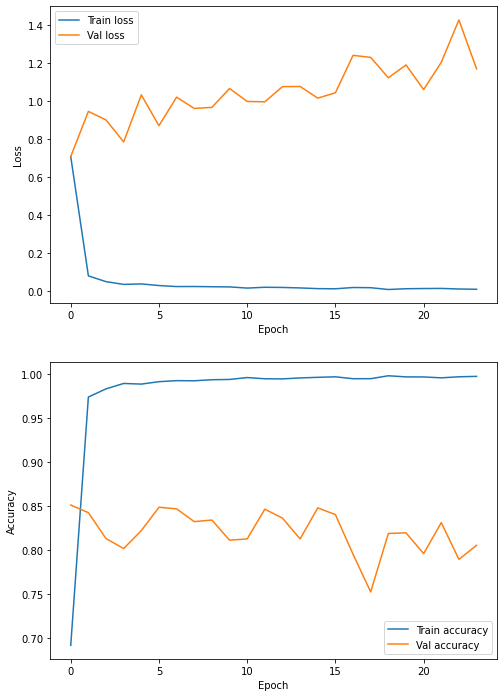

In [7]:
# visualize history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

### 모델 저장 및 로딩 

In [8]:
# save model
cnn_meta.save("./models/Dilated_3D_cnn_meta_aug_oversampling.h5")

# model load하는 경우
cnn_meta  = tf.keras.models.load_model("./models/Dilated_3D_cnn_meta_aug_oversampling.h5")

## Confusion Matrix
- X train을 통한 메트릭스
- X test를 통한 메트릭스

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [10]:
def output_class(x):
    output = np.argmax(x)
    if output == 0:
        return 'non-ROI'
    elif output == 1:
        return 'metastasis'
    elif output == 2:
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'

In [11]:
# X_train을 통한 예측값 비교
y_pred = cnn_meta.predict([X_i_tr,X_m_tr])
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[5830    0    0    2]
 [   0 2776    0    0]
 [   0    0 8920   16]
 [   4    4   11 8443]]
                    precision    recall  f1-score   support

               HCC       1.00      1.00      1.00      5832
cholangiocarcinoma       1.00      1.00      1.00      2776
        metastasis       1.00      1.00      1.00      8936
           non-ROI       1.00      1.00      1.00      8462

          accuracy                           1.00     26006
         macro avg       1.00      1.00      1.00     26006
      weighted avg       1.00      1.00      1.00     26006



In [13]:
# X test 를 이용한 Y 값 예측    
y_pred = cnn_meta.predict([X_i_te,X_m_te])    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[   1    0    6   69]
 [  41    0    0   40]
 [  22    0   40  192]
 [  48    0   81 2212]]
                    precision    recall  f1-score   support

               HCC       0.01      0.01      0.01        76
cholangiocarcinoma       0.00      0.00      0.00        81
        metastasis       0.31      0.16      0.21       254
           non-ROI       0.88      0.94      0.91      2341

          accuracy                           0.82      2752
         macro avg       0.30      0.28      0.28      2752
      weighted avg       0.78      0.82      0.79      2752



### CAM

In [23]:
print(cnn_meta.predict([X_i_te,X_m_te])[0])

[9.9977452e-01 6.1439314e-05 7.9409030e-05 8.4575222e-05]


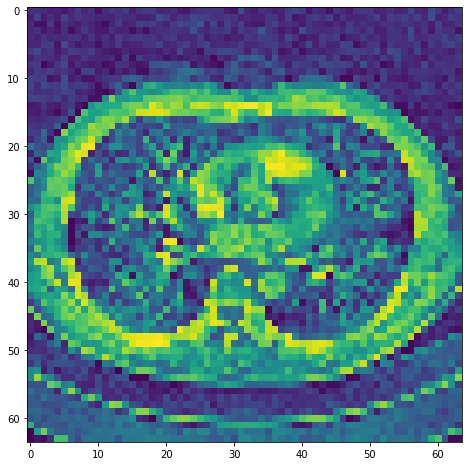

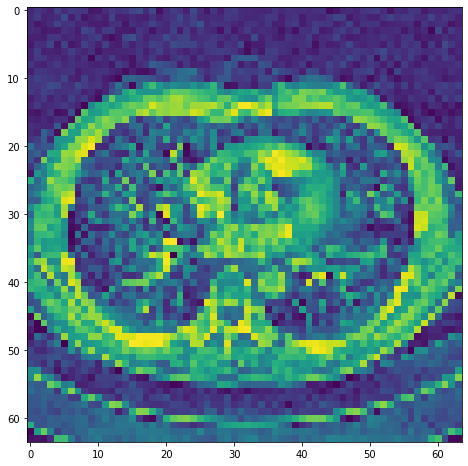

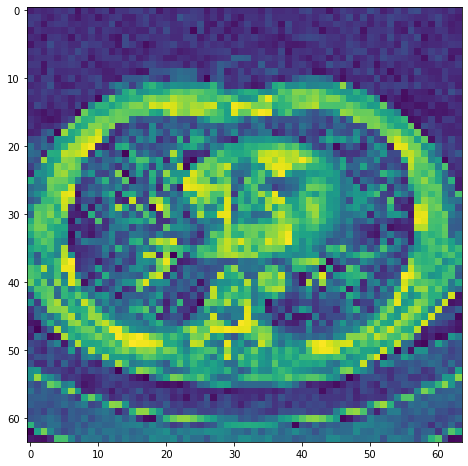

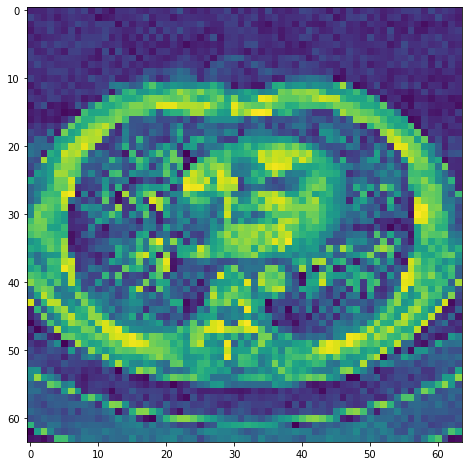

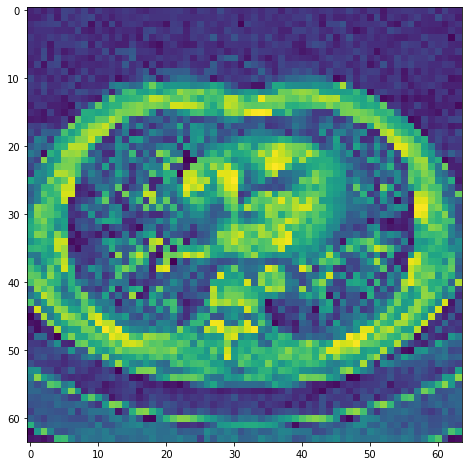

In [48]:
f, ax = plt.subplots(1,1,figsize=(18,8)) 

for i in range(5): 
    X_i_tr[0][:,:,i].shape
    img = X_i_tr[0][:,:,i]
    img = np.expand_dims(img, axis=2)
    #img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # 2차원 배열을 3차원으로 3번 복사 
    img.shape
    
    ax.imshow(img)